# Module 1: Financial Risk Metrics and Applications

This notebook demonstrates practical applications of probability theory in quantitative finance, focusing on risk measurement and portfolio analysis.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Calculate Value-at-Risk (VaR) using multiple methods
2. Compute Conditional VaR (Expected Shortfall)
3. Apply Monte Carlo simulation to option pricing
4. Calculate risk-adjusted performance metrics (Sharpe, Sortino)
5. Analyze real market data distributions
6. Model heavy-tailed distributions in finance

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, t as student_t
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Fetching Real Market Data

Let's start by downloading real stock price data and calculating returns.

In [4]:
# Fetch historical data for major stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'SPY']  # SPY is S&P 500 ETF
start_date = '2020-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print(f"Downloading data from {start_date} to {end_date}...")
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, progress=False)

# Extract closing prices
prices = data['Close']
print(f"\nData shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
prices.head()


Data shape: (1472, 5)
Date range: 2020-01-02 00:00:00 to 2025-11-07 00:00:00


Ticker,AAPL,AMZN,GOOGL,MSFT,SPY
Date,,,,,
2020-01-02,72.538521,94.900497,67.965240,152.791138,298.578705
2020-01-03,71.833305,93.748497,67.609688,150.888611,296.317749
2020-01-06,72.405685,95.143997,69.411758,151.278656,297.448181
2020-01-07,72.065155,95.343002,69.277687,149.899292,296.611908
2020-01-08,73.224426,94.598503,69.770775,152.286957,298.192627


Summary Statistics of Daily Returns:

Ticker         AAPL         AMZN        GOOGL         MSFT          SPY
count   1471.000000  1471.000000  1471.000000  1471.000000  1471.000000
mean       0.001094     0.000899     0.001170     0.000977     0.000638
std        0.020234     0.022643     0.020470     0.018743     0.013177
min       -0.128647    -0.140494    -0.116341    -0.147390    -0.109424
25%       -0.008316    -0.011107    -0.009423    -0.007894    -0.004916
50%        0.001140     0.000780     0.001789     0.000978     0.000973
75%        0.011590     0.012956     0.011627     0.010485     0.006894
max        0.153288     0.135359     0.102244     0.142169     0.105019


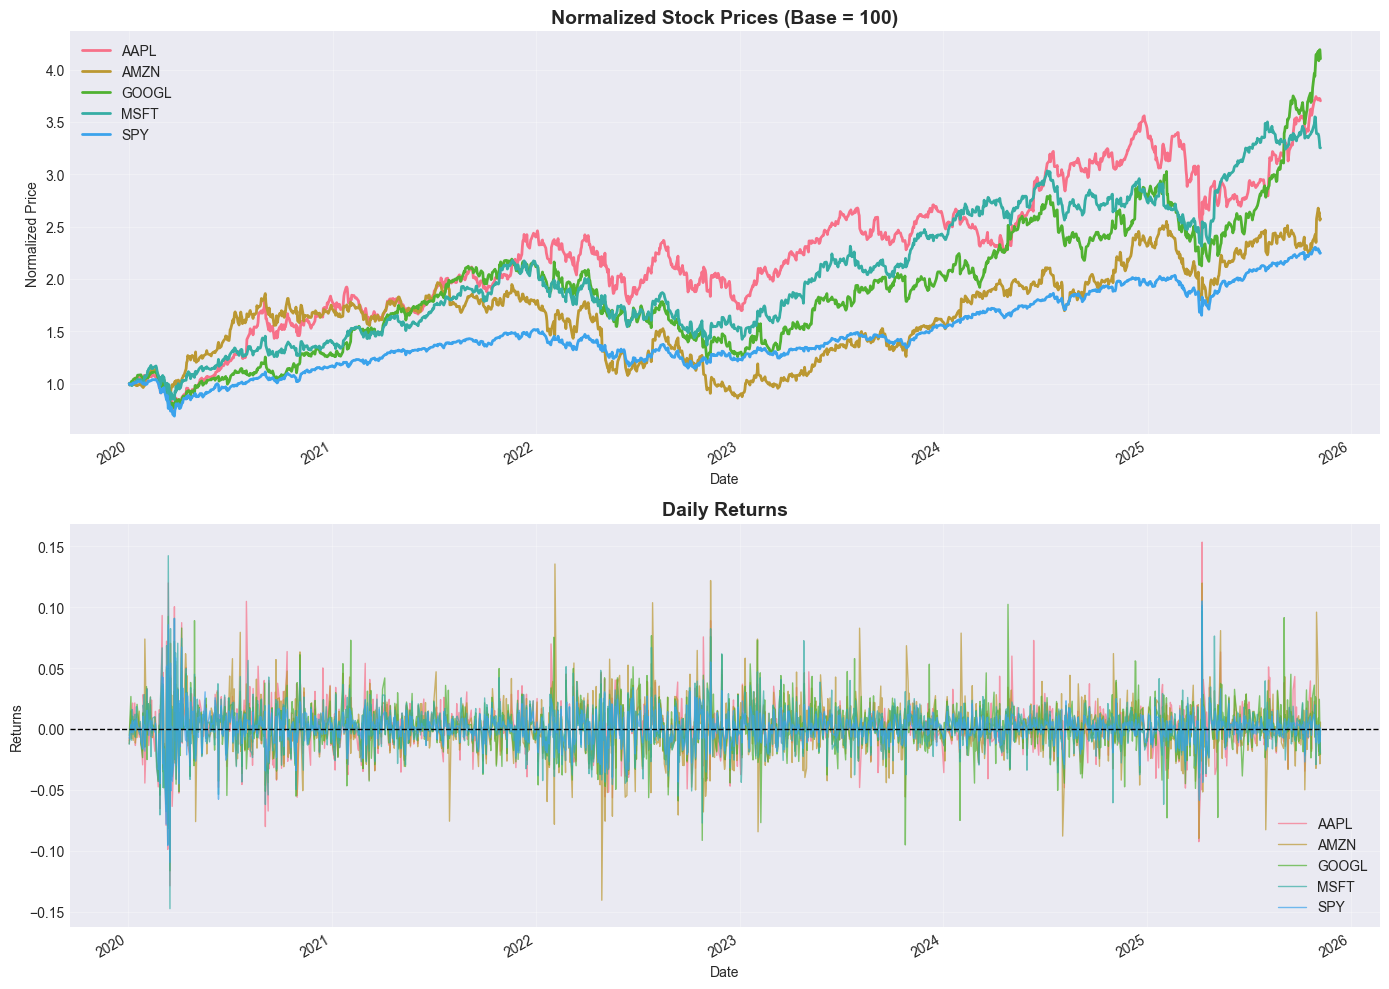

In [5]:
# Calculate daily returns
returns = prices.pct_change().dropna()

# Display summary statistics
print("Summary Statistics of Daily Returns:\n")
print(returns.describe())

# Plot price evolution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Normalized prices
normalized_prices = prices / prices.iloc[0]
normalized_prices.plot(ax=ax1, linewidth=2)
ax1.set_title('Normalized Stock Prices (Base = 100)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Normalized Price')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Returns distribution
returns.plot(ax=ax2, linewidth=1, alpha=0.7)
ax2.set_title('Daily Returns', fontsize=14, fontweight='bold')
ax2.set_ylabel('Returns')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Value-at-Risk (VaR) Calculation

VaR answers the question: *"What is the maximum loss we can expect with X% confidence over a given time horizon?"*

We'll implement three methods:
1. **Historical VaR**: Using empirical distribution
2. **Parametric VaR**: Assuming normal distribution
3. **Cornish-Fisher VaR**: Adjusting for skewness and kurtosis

In [6]:
def calculate_var(returns, confidence_level=0.95, method='historical'):
    """
    Calculate Value-at-Risk (VaR).
    
    Parameters:
    -----------
    returns : pd.Series or np.array
        Returns series
    confidence_level : float, default 0.95
        Confidence level (e.g., 0.95 for 95% VaR)
    method : str, default 'historical'
        Method: 'historical', 'parametric', or 'cornish-fisher'
    
    Returns:
    --------
    float : VaR (positive value represents potential loss)
    """
    if method == 'historical':
        # Historical method: use empirical quantile
        var = -np.percentile(returns, (1 - confidence_level) * 100)
        
    elif method == 'parametric':
        # Parametric method: assume normal distribution
        mu = returns.mean()
        sigma = returns.std()
        z_score = norm.ppf(1 - confidence_level)
        var = -(mu + sigma * z_score)
        
    elif method == 'cornish-fisher':
        # Cornish-Fisher: adjust for skewness and kurtosis
        mu = returns.mean()
        sigma = returns.std()
        skew = returns.skew()
        kurt = returns.kurtosis()
        
        z = norm.ppf(1 - confidence_level)
        z_cf = (z + 
                (z**2 - 1) * skew / 6 + 
                (z**3 - 3*z) * kurt / 24 - 
                (2*z**3 - 5*z) * skew**2 / 36)
        
        var = -(mu + sigma * z_cf)
    else:
        raise ValueError("method must be 'historical', 'parametric', or 'cornish-fisher'")
    
    return var


def calculate_cvar(returns, confidence_level=0.95):
    """
    Calculate Conditional VaR (CVaR) / Expected Shortfall.
    
    CVaR is the expected loss given that we are in the tail beyond VaR.
    """
    var = -np.percentile(returns, (1 - confidence_level) * 100)
    # Calculate mean of losses beyond VaR
    tail_losses = returns[returns <= -var]
    cvar = -tail_losses.mean() if len(tail_losses) > 0 else 0.0
    return cvar


# Calculate VaR and CVaR for AAPL
aapl_returns = returns['AAPL']
confidence_levels = [0.90, 0.95, 0.99]

print("Apple (AAPL) Risk Metrics:\n")
print("="*60)

for conf in confidence_levels:
    var_hist = calculate_var(aapl_returns, conf, 'historical')
    var_param = calculate_var(aapl_returns, conf, 'parametric')
    var_cf = calculate_var(aapl_returns, conf, 'cornish-fisher')
    cvar = calculate_cvar(aapl_returns, conf)
    
    print(f"\n{conf*100}% Confidence Level:")
    print(f"  Historical VaR:      {var_hist:.4%}")
    print(f"  Parametric VaR:      {var_param:.4%}")
    print(f"  Cornish-Fisher VaR:  {var_cf:.4%}")
    print(f"  CVaR (ES):           {cvar:.4%}")

print("\n" + "="*60)

Apple (AAPL) Risk Metrics:


90.0% Confidence Level:
  Historical VaR:      2.1148%
  Parametric VaR:      2.4837%
  Cornish-Fisher VaR:  1.4574%
  CVaR (ES):           3.5528%

95.0% Confidence Level:
  Historical VaR:      3.1185%
  Parametric VaR:      3.2188%
  Cornish-Fisher VaR:  2.7830%
  CVaR (ES):           4.5016%

99.0% Confidence Level:
  Historical VaR:      5.0425%
  Parametric VaR:      4.5977%
  Cornish-Fisher VaR:  7.2654%
  CVaR (ES):           7.1956%



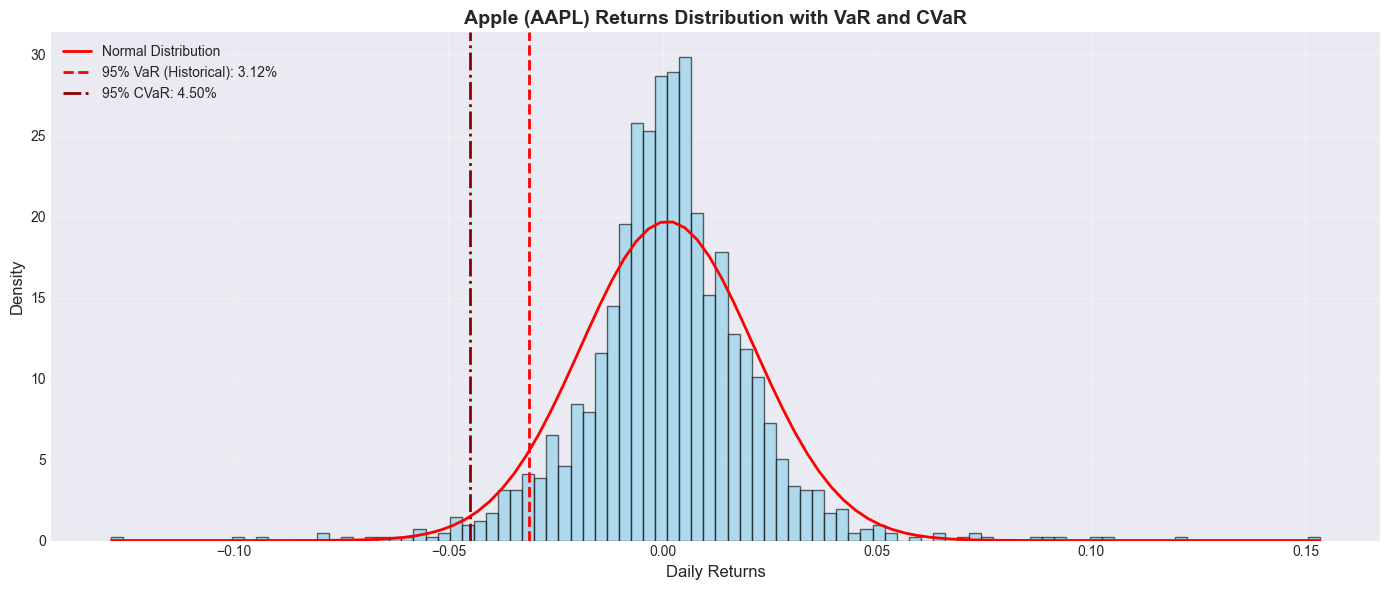

In [7]:
# Visualize VaR
fig, ax = plt.subplots(figsize=(14, 6))

# Plot histogram of returns
ax.hist(aapl_returns, bins=100, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Overlay normal distribution
mu, sigma = aapl_returns.mean(), aapl_returns.std()
x = np.linspace(aapl_returns.min(), aapl_returns.max(), 100)
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')

# Mark VaR levels
var_95_hist = -np.percentile(aapl_returns, 5)
var_95_param = -(mu + sigma * norm.ppf(0.05))
cvar_95 = calculate_cvar(aapl_returns, 0.95)

ax.axvline(-var_95_hist, color='red', linestyle='--', linewidth=2, label=f'95% VaR (Historical): {var_95_hist:.2%}')
ax.axvline(-cvar_95, color='darkred', linestyle='-.', linewidth=2, label=f'95% CVaR: {cvar_95:.2%}')

ax.set_xlabel('Daily Returns', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Apple (AAPL) Returns Distribution with VaR and CVaR', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Risk-Adjusted Performance Metrics

Raw returns don't tell the full story. We need to adjust for risk.

In [8]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=252):
    """
    Calculate annualized Sharpe ratio.
    
    Sharpe Ratio = (Return - Risk_Free_Rate) / Volatility
    """
    excess_returns = returns - risk_free_rate / periods_per_year
    return np.sqrt(periods_per_year) * excess_returns.mean() / excess_returns.std()


def calculate_sortino_ratio(returns, risk_free_rate=0.02, periods_per_year=252):
    """
    Calculate annualized Sortino ratio (uses downside deviation).
    
    Sortino focuses only on downside volatility, which is more relevant for risk-averse investors.
    """
    excess_returns = returns - risk_free_rate / periods_per_year
    downside_returns = excess_returns[excess_returns < 0]
    downside_std = np.sqrt(np.mean(downside_returns**2))
    
    if downside_std == 0:
        return 0.0
    
    return np.sqrt(periods_per_year) * excess_returns.mean() / downside_std


def calculate_max_drawdown(returns):
    """
    Calculate maximum drawdown.
    
    Maximum drawdown is the largest peak-to-trough decline in cumulative returns.
    """
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    return abs(drawdown.min())


# Calculate metrics for all stocks
metrics_df = pd.DataFrame(index=tickers)

for ticker in tickers:
    stock_returns = returns[ticker]
    
    metrics_df.loc[ticker, 'Ann. Return'] = stock_returns.mean() * 252
    metrics_df.loc[ticker, 'Ann. Volatility'] = stock_returns.std() * np.sqrt(252)
    metrics_df.loc[ticker, 'Sharpe Ratio'] = calculate_sharpe_ratio(stock_returns)
    metrics_df.loc[ticker, 'Sortino Ratio'] = calculate_sortino_ratio(stock_returns)
    metrics_df.loc[ticker, 'Max Drawdown'] = calculate_max_drawdown(stock_returns)
    metrics_df.loc[ticker, '95% VaR'] = calculate_var(stock_returns, 0.95, 'historical')
    metrics_df.loc[ticker, '95% CVaR'] = calculate_cvar(stock_returns, 0.95)

print("\nRisk-Adjusted Performance Metrics:\n")
print(metrics_df.round(4))


Risk-Adjusted Performance Metrics:

       Ann. Return  Ann. Volatility  Sharpe Ratio  Sortino Ratio  \
AAPL        0.2757           0.3212        0.7960         0.8090   
MSFT        0.2463           0.2975        0.7606         0.7704   
GOOGL       0.2947           0.3250        0.8454         0.8324   
AMZN        0.2266           0.3594        0.5747         0.5839   
SPY         0.1607           0.2092        0.6725         0.6349   

       Max Drawdown  95% VaR  95% CVaR  
AAPL         0.3336   0.0312    0.0450  
MSFT         0.3715   0.0279    0.0416  
GOOGL        0.4432   0.0311    0.0464  
AMZN         0.5615   0.0330    0.0502  
SPY          0.3372   0.0185    0.0316  


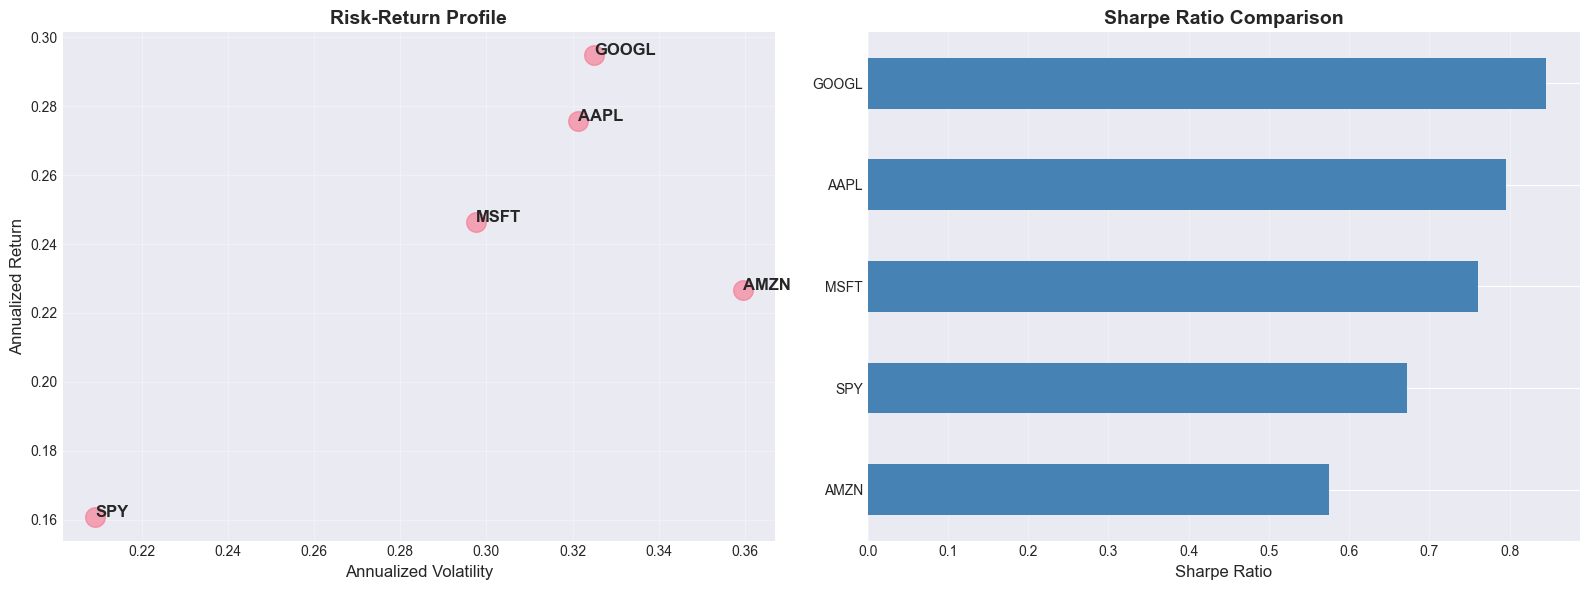

In [9]:
# Visualize risk-return tradeoff
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Risk-Return scatter
ax1.scatter(metrics_df['Ann. Volatility'], metrics_df['Ann. Return'], s=200, alpha=0.6)
for ticker in tickers:
    ax1.annotate(ticker, 
                (metrics_df.loc[ticker, 'Ann. Volatility'], 
                 metrics_df.loc[ticker, 'Ann. Return']),
                fontsize=12, fontweight='bold')
ax1.set_xlabel('Annualized Volatility', fontsize=12)
ax1.set_ylabel('Annualized Return', fontsize=12)
ax1.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Sharpe ratios comparison
metrics_df['Sharpe Ratio'].sort_values().plot(kind='barh', ax=ax2, color='steelblue')
ax2.set_xlabel('Sharpe Ratio', fontsize=12)
ax2.set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 4. Monte Carlo Simulation for Option Pricing

Monte Carlo simulation is a powerful technique for pricing complex derivatives.

In [10]:
def monte_carlo_european_option(S0, K, T, r, sigma, option_type='call', n_simulations=100000):
    """
    Price European option using Monte Carlo simulation.
    
    Parameters:
    -----------
    S0 : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to maturity (years)
    r : float
        Risk-free rate
    sigma : float
        Volatility
    option_type : str
        'call' or 'put'
    n_simulations : int
        Number of Monte Carlo paths
    
    Returns:
    --------
    tuple : (option_price, standard_error, simulated_prices)
    """
    # Simulate stock price at maturity using Geometric Brownian Motion
    # S_T = S_0 * exp((r - 0.5*sigma^2)*T + sigma*sqrt(T)*Z)
    Z = np.random.standard_normal(n_simulations)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # Calculate payoffs
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - ST, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    # Discount to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)
    standard_error = np.exp(-r * T) * np.std(payoffs) / np.sqrt(n_simulations)
    
    return option_price, standard_error, ST


# Example: Price a call option on Apple
# Current Apple price
S0 = prices['AAPL'].iloc[-1]
K = 1.1*S0  # At-the-money
T = 1.0  # 1 year
r = 0.05  # 5% risk-free rate
sigma = aapl_returns.std() * np.sqrt(252)  # Annualized volatility

print("\nMonte Carlo Option Pricing for Apple (AAPL)")
print("="*60)
print(f"Current Stock Price (S0): ${S0:.2f}")
print(f"Strike Price (K):         ${K:.2f}")
print(f"Time to Maturity (T):     {T} year")
print(f"Risk-free Rate (r):       {r:.2%}")
print(f"Volatility (σ):           {sigma:.2%}")
print("="*60)

# Price call option
call_price, call_se, ST_call = monte_carlo_european_option(S0, K, T, r, sigma, 'call', 100000)
print(f"\nCall Option Price:  ${call_price:.4f} ± ${call_se:.4f}")

# Price put option
put_price, put_se, ST_put = monte_carlo_european_option(S0, K, T, r, sigma, 'put', 100000)
print(f"Put Option Price:   ${put_price:.4f} ± ${put_se:.4f}")

# Verify Put-Call Parity: C - P = S0*e^(-q*T) - K*e^(-r*T)
# For no dividends (q=0): C - P = S0 - K*e^(-r*T)
parity_lhs = call_price - put_price
parity_rhs = S0 - K * np.exp(-r * T)
print(f"\nPut-Call Parity Check:")
print(f"  C - P = ${parity_lhs:.4f}")
print(f"  S - K*e^(-rT) = ${parity_rhs:.4f}")
print(f"  Difference: ${abs(parity_lhs - parity_rhs):.4f}")


Monte Carlo Option Pricing for Apple (AAPL)
Current Stock Price (S0): $268.47
Strike Price (K):         $295.32
Time to Maturity (T):     1.0 year
Risk-free Rate (r):       5.00%
Volatility (σ):           32.12%

Call Option Price:  $28.9627 ± $0.1799
Put Option Price:   $41.4749 ± $0.1462

Put-Call Parity Check:
  C - P = $-12.5122
  S - K*e^(-rT) = $-12.4442
  Difference: $0.0680


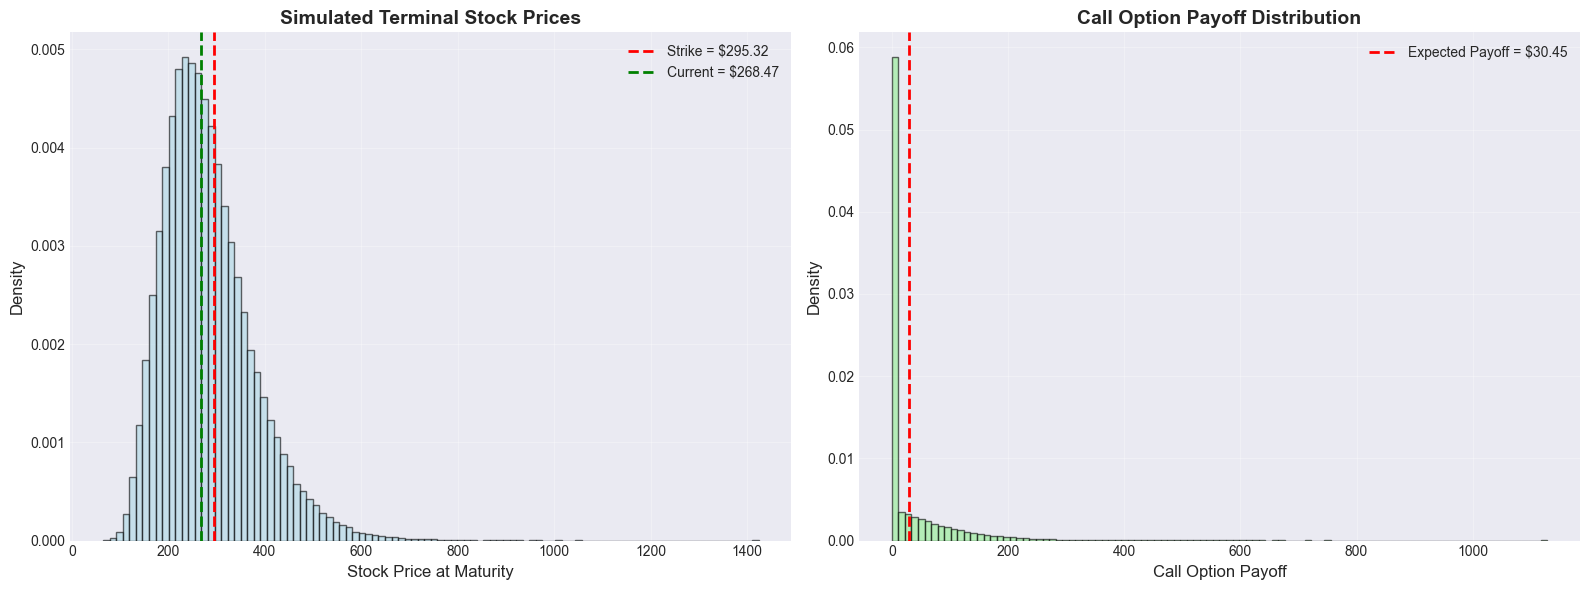

In [11]:
# Visualize Monte Carlo simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of terminal stock prices
ax1.hist(ST_call, bins=100, density=True, alpha=0.6, color='lightblue', edgecolor='black')
ax1.axvline(K, color='red', linestyle='--', linewidth=2, label=f'Strike = ${K:.2f}')
ax1.axvline(S0, color='green', linestyle='--', linewidth=2, label=f'Current = ${S0:.2f}')
ax1.set_xlabel('Stock Price at Maturity', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Simulated Terminal Stock Prices', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Call option payoff distribution
call_payoffs = np.maximum(ST_call - K, 0)
ax2.hist(call_payoffs, bins=100, density=True, alpha=0.6, color='lightgreen', edgecolor='black')
ax2.axvline(call_price * np.exp(r * T), color='red', linestyle='--', linewidth=2, 
           label=f'Expected Payoff = ${call_price * np.exp(r * T):.2f}')
ax2.set_xlabel('Call Option Payoff', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Call Option Payoff Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Heavy-Tailed Distributions in Finance

Financial returns often exhibit heavier tails than the normal distribution, leading to underestimation of extreme events.

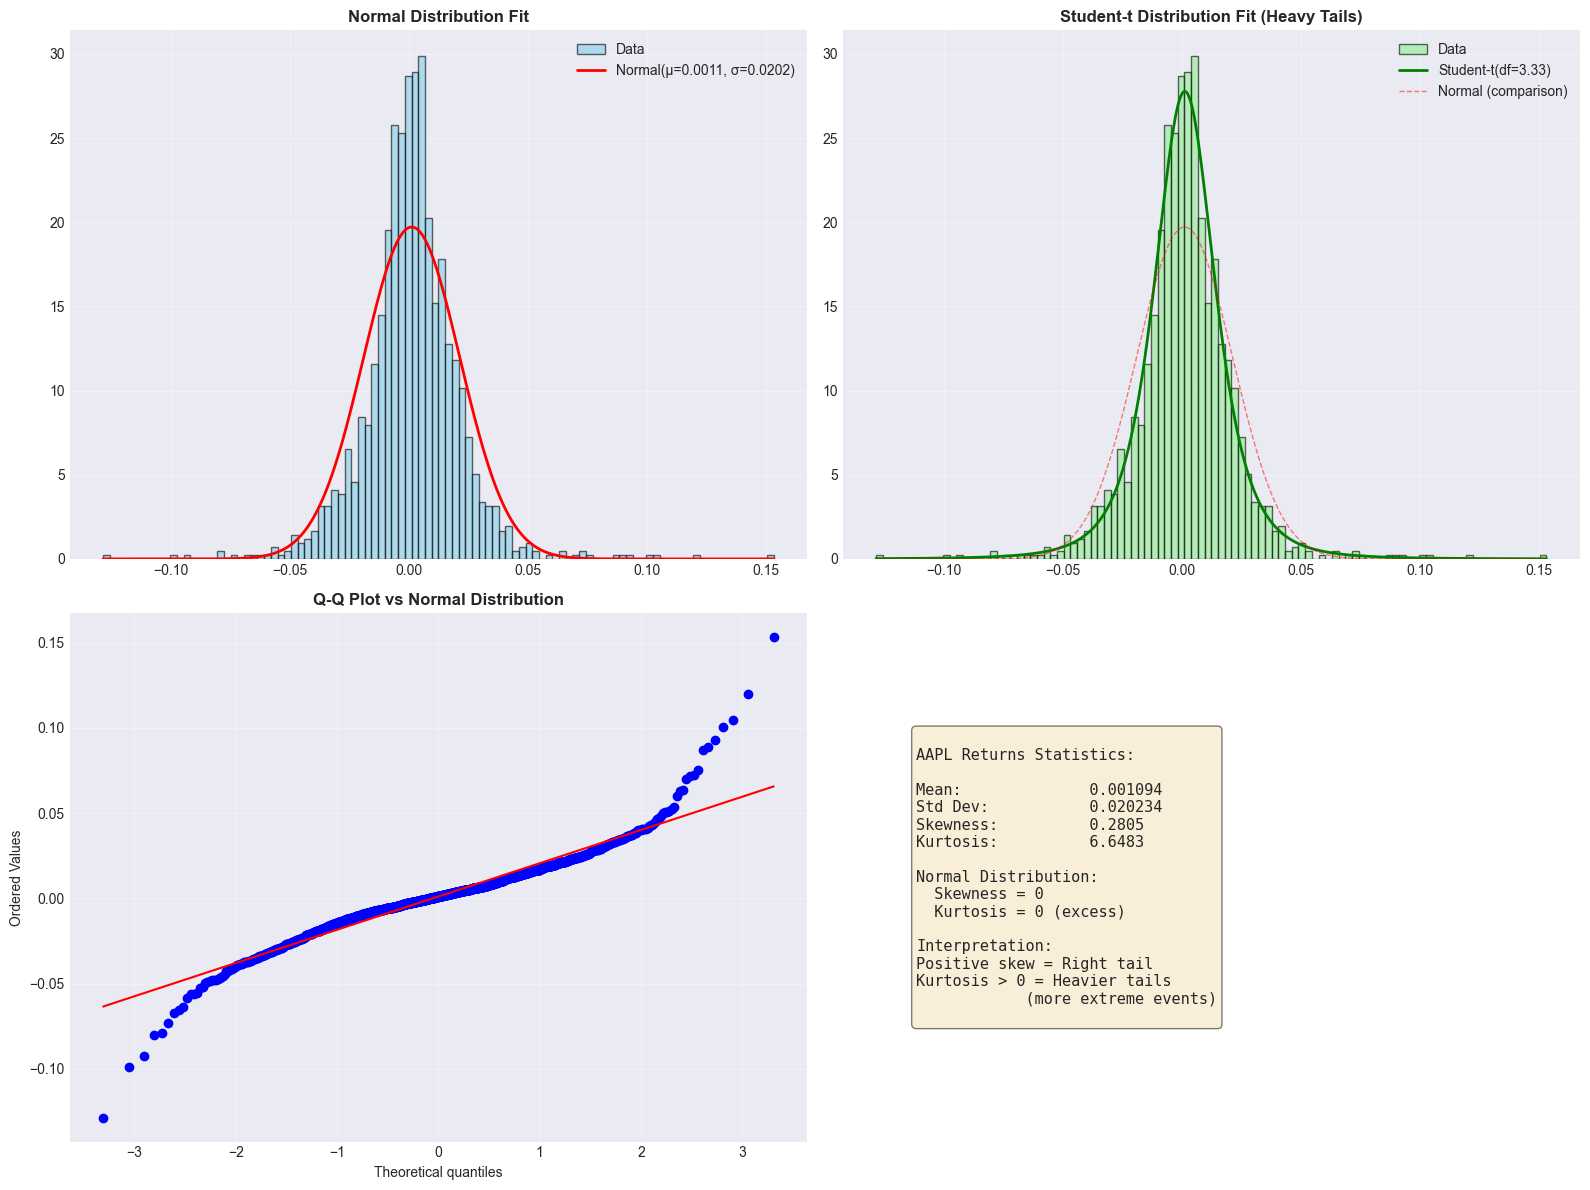


Key Observations:
1. Real returns have heavier tails than normal distribution
2. Student-t distribution provides better fit
3. Extreme events occur more frequently than normal model predicts
4. This has important implications for risk management


In [10]:
# Fit different distributions to AAPL returns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Normal distribution
ax = axes[0, 0]
ax.hist(aapl_returns, bins=100, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Data')
mu, sigma = aapl_returns.mean(), aapl_returns.std()
x = np.linspace(aapl_returns.min(), aapl_returns.max(), 1000)
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal(μ={mu:.4f}, σ={sigma:.4f})')
ax.set_title('Normal Distribution Fit', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Student-t distribution (heavier tails)
ax = axes[0, 1]
ax.hist(aapl_returns, bins=100, density=True, alpha=0.6, color='lightgreen', edgecolor='black', label='Data')
# Fit Student-t
params = student_t.fit(aapl_returns)
df, loc, scale = params
ax.plot(x, student_t.pdf(x, df, loc, scale), 'g-', linewidth=2, 
       label=f'Student-t(df={df:.2f})')
ax.plot(x, norm.pdf(x, mu, sigma), 'r--', linewidth=1, alpha=0.5, label='Normal (comparison)')
ax.set_title('Student-t Distribution Fit (Heavy Tails)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Q-Q Plot vs Normal
ax = axes[1, 0]
stats.probplot(aapl_returns, dist="norm", plot=ax)
ax.set_title('Q-Q Plot vs Normal Distribution', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Statistics comparison
ax = axes[1, 1]
stats_text = f"""
AAPL Returns Statistics:

Mean:              {aapl_returns.mean():.6f}
Std Dev:           {aapl_returns.std():.6f}
Skewness:          {aapl_returns.skew():.4f}
Kurtosis:          {aapl_returns.kurtosis():.4f}

Normal Distribution:
  Skewness = 0
  Kurtosis = 0 (excess)

Interpretation:
{'Negative' if aapl_returns.skew() < 0 else 'Positive'} skew = {'Left' if aapl_returns.skew() < 0 else 'Right'} tail
Kurtosis > 0 = Heavier tails
            (more extreme events)
"""
ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=11, 
       verticalalignment='center', fontfamily='monospace',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.axis('off')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("1. Real returns have heavier tails than normal distribution")
print("2. Student-t distribution provides better fit")
print("3. Extreme events occur more frequently than normal model predicts")
print("4. This has important implications for risk management")

## 6. Portfolio Risk Analysis

Let's analyze a simple portfolio consisting of multiple stocks.

In [11]:
# Create equal-weighted portfolio
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Equal weights
portfolio_returns = (returns[tickers] * weights).sum(axis=1)

# Calculate portfolio metrics
print("\nPortfolio Analysis (Equal-Weighted)")
print("="*60)
print(f"\nWeights: {dict(zip(tickers, weights))}")
print(f"\nAnnualized Return:     {portfolio_returns.mean() * 252:.2%}")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(252):.2%}")
print(f"Sharpe Ratio:          {calculate_sharpe_ratio(portfolio_returns):.4f}")
print(f"Maximum Drawdown:      {calculate_max_drawdown(portfolio_returns):.2%}")
print(f"95% VaR:               {calculate_var(portfolio_returns, 0.95, 'historical'):.2%}")
print(f"95% CVaR:              {calculate_cvar(portfolio_returns, 0.95):.2%}")

# Compare individual vs portfolio risk
print("\n" + "="*60)
print("Diversification Benefit:")
print("="*60)
avg_individual_vol = returns[tickers].std().mean() * np.sqrt(252)
portfolio_vol = portfolio_returns.std() * np.sqrt(252)
diversification_benefit = (avg_individual_vol - portfolio_vol) / avg_individual_vol
print(f"Average Individual Volatility: {avg_individual_vol:.2%}")
print(f"Portfolio Volatility:          {portfolio_vol:.2%}")
print(f"Risk Reduction:                {diversification_benefit:.2%}")


Portfolio Analysis (Equal-Weighted)

Weights: {'AAPL': np.float64(0.2), 'MSFT': np.float64(0.2), 'GOOGL': np.float64(0.2), 'AMZN': np.float64(0.2), 'SPY': np.float64(0.2)}

Annualized Return:     24.08%
Annualized Volatility: 26.12%
Sharpe Ratio:          0.8452
Maximum Drawdown:      35.26%
95% VaR:               2.51%
95% CVaR:              3.80%

Diversification Benefit:
Average Individual Volatility: 30.25%
Portfolio Volatility:          26.12%
Risk Reduction:                13.63%


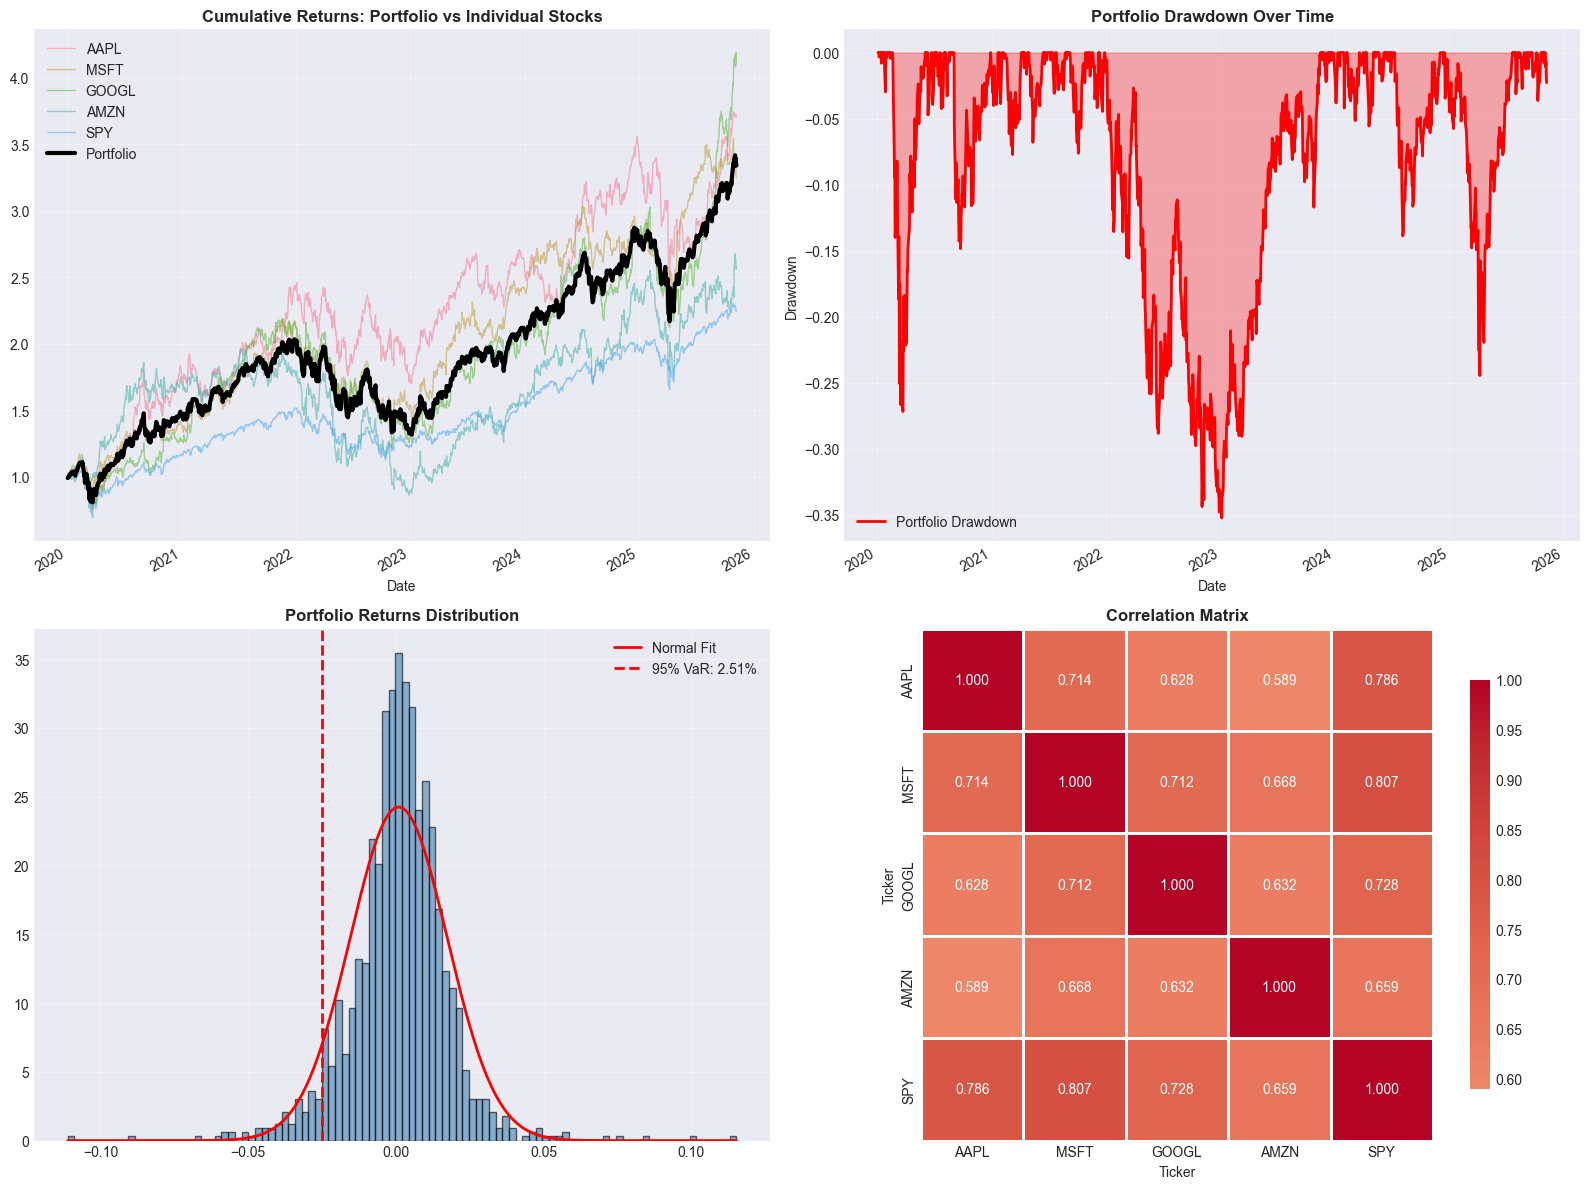

In [12]:
# Visualize portfolio performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cumulative returns
ax = axes[0, 0]
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_individual = (1 + returns[tickers]).cumprod()
cumulative_individual.plot(ax=ax, alpha=0.5, linewidth=1)
cumulative_portfolio.plot(ax=ax, color='black', linewidth=3, label='Portfolio')
ax.set_title('Cumulative Returns: Portfolio vs Individual Stocks', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 2. Drawdown
ax = axes[0, 1]
running_max = cumulative_portfolio.expanding().max()
drawdown = (cumulative_portfolio - running_max) / running_max
drawdown.plot(ax=ax, color='red', linewidth=2, label='Portfolio Drawdown')
ax.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
ax.set_title('Portfolio Drawdown Over Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Drawdown')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Returns distribution
ax = axes[1, 0]
ax.hist(portfolio_returns, bins=100, density=True, alpha=0.6, color='steelblue', edgecolor='black')
mu, sigma = portfolio_returns.mean(), portfolio_returns.std()
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Fit')
var_95 = calculate_var(portfolio_returns, 0.95, 'historical')
ax.axvline(-var_95, color='red', linestyle='--', linewidth=2, label=f'95% VaR: {var_95:.2%}')
ax.set_title('Portfolio Returns Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Correlation matrix
ax = axes[1, 1]
corr_matrix = returns[tickers].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
           square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Key Takeaways

1. **VaR and CVaR**: Essential risk metrics, but parametric VaR can underestimate risk during market stress

2. **Risk-Adjusted Metrics**: Sharpe and Sortino ratios help compare investments on a risk-adjusted basis

3. **Monte Carlo**: Powerful for pricing complex derivatives and analyzing portfolio scenarios

4. **Heavy Tails**: Financial returns have fatter tails than normal distribution → extreme events are more likely

5. **Diversification**: Portfolio risk < sum of individual risks due to imperfect correlations

6. **Real Data**: Always validate models with real market data, not just theoretical distributions

## Exercises

1. Calculate VaR for different confidence levels (90%, 95%, 99%) and compare
2. Implement variance reduction techniques for Monte Carlo (antithetic variates, control variates)
3. Build a minimum variance portfolio using optimization
4. Backtest a VaR model using historical data
5. Implement Extreme Value Theory (EVT) for tail risk estimation

## 📝 Guided Exercises with Auto-Validation

**Instructions:** Complete the exercises below. Each exercise has assert statements that will automatically check your answer. When you run the cell and see no errors, your solution is correct! ✅

### Exercise 1: Calculate Returns (Beginner)

Calculate daily returns for a simple price series and verify basic properties.

In [14]:
# Exercise 1: Calculate daily returns
import numpy as np
import pandas as pd

# Given: Price series
prices = pd.Series([100, 102, 101, 105, 103], 
                   index=pd.date_range('2024-01-01', periods=5))

# TODO: Calculate percentage returns (price change / previous price * 100)
# Hint: Use pct_change() or manual calculation
returns = 100 *prices.pct_change()  # Replace with your calculation

# ============= AUTO-VALIDATION (DO NOT MODIFY) =============
assert returns is not None, "❌ Calculate the returns first!"
assert isinstance(returns, pd.Series), "❌ Returns should be a pandas Series"
assert len(returns) == 5, "❌ Returns series should have same length as prices"
assert pd.isna(returns.iloc[0]), "❌ First return should be NaN"
assert np.isclose(returns.iloc[1], 2.0, rtol=0.01), f"❌ Second return should be ~2.0%, got {returns.iloc[1]:.2f}%"
assert np.isclose(returns.iloc[2], -0.98, rtol=0.01), f"❌ Third return calculation is incorrect"
print("✅ Exercise 1 Complete! Returns calculated correctly.")
print(f"   Mean return: {returns.mean():.3f}%")
# =========================================================

✅ Exercise 1 Complete! Returns calculated correctly.
   Mean return: 0.769%


### Exercise 2: Historical VaR Calculation (Intermediate)

Calculate Value at Risk using the historical method.

In [16]:
# Exercise 2: Calculate Historical VaR
np.random.seed(42)
portfolio_value = 1_000_000  # $1 million portfolio
returns = np.random.normal(0.0005, 0.02, 1000)  # 1000 daily returns

# TODO: Calculate 95% and 99% Historical VaR
# Hint: Use np.percentile() to find the 5th and 1st percentiles
# VaR is the negative of the percentile (we want losses)
confidence_95 = 0.95
confidence_99 = 0.99

var_95 = portfolio_value * np.percentile(returns, 100 * (1 - confidence_95))  # Calculate 95% VaR (in dollars)
var_99 = portfolio_value * np.percentile(returns, 100 * (1 - confidence_99))  # Calculate 99% VaR (in dollars)

# ============= AUTO-VALIDATION (DO NOT MODIFY) =============
assert var_95 is not None, "❌ Calculate the 95% VaR!"
assert var_99 is not None, "❌ Calculate the 99% VaR!"
assert var_95 < 0, "❌ VaR should be negative (represents a loss)"
assert var_99 < 0, "❌ VaR should be negative (represents a loss)"
assert var_99 < var_95, "❌ 99% VaR should be larger (more negative) than 95% VaR"
assert -40000 < var_95 < -20000, f"❌ 95% VaR seems incorrect: ${var_95:,.0f}"
assert -60000 < var_99 < -35000, f"❌ 99% VaR seems incorrect: ${var_99:,.0f}"
print("✅ Exercise 2 Complete! VaR calculated correctly.")
print(f"   95% VaR: ${var_95:,.0f}")
print(f"   99% VaR: ${var_99:,.0f}")
print(f"   Interpretation: We expect losses to exceed ${-var_95:,.0f} only 5% of the time")
# =========================================================

✅ Exercise 2 Complete! VaR calculated correctly.
   95% VaR: $-30,019
   99% VaR: $-41,147
   Interpretation: We expect losses to exceed $30,019 only 5% of the time


### Exercise 3: Sharpe Ratio Calculation (Intermediate)

Calculate the Sharpe ratio for a portfolio given returns and risk-free rate.

In [17]:
# Exercise 3: Calculate Sharpe Ratio
np.random.seed(123)
daily_returns = np.random.normal(0.0008, 0.015, 252)  # One year of daily returns
risk_free_rate_annual = 0.02  # 2% annual risk-free rate

# TODO: Calculate annualized Sharpe Ratio
# Formula: (Annualized Return - Risk Free Rate) / Annualized Volatility
# Annualization: multiply mean by 252, multiply std by sqrt(252)

annualized_return = daily_returns.mean() * 252  # Calculate annualized portfolio return
annualized_volatility = daily_returns.std() * np.sqrt(252)  # Calculate annualized volatility
sharpe_ratio = (annualized_return - risk_free_rate_annual) / annualized_volatility  # Calculate Sharpe ratio

# ============= AUTO-VALIDATION (DO NOT MODIFY) =============
assert annualized_return is not None, "❌ Calculate annualized return!"
assert annualized_volatility is not None, "❌ Calculate annualized volatility!"
assert sharpe_ratio is not None, "❌ Calculate Sharpe ratio!"
assert 0.15 < annualized_return < 0.25, f"❌ Annualized return seems wrong: {annualized_return:.2%}"
assert 0.20 < annualized_volatility < 0.30, f"❌ Annualized volatility seems wrong: {annualized_volatility:.2%}"
assert 0.5 < sharpe_ratio < 1.5, f"❌ Sharpe ratio seems incorrect: {sharpe_ratio:.2f}"
expected_sharpe = (daily_returns.mean() * 252 - risk_free_rate_annual) / (daily_returns.std() * np.sqrt(252))
assert np.isclose(sharpe_ratio, expected_sharpe, rtol=0.01), f"❌ Sharpe calculation error. Expected {expected_sharpe:.3f}, got {sharpe_ratio:.3f}"
print("✅ Exercise 3 Complete! Sharpe Ratio calculated correctly.")
print(f"   Annualized Return: {annualized_return:.2%}")
print(f"   Annualized Volatility: {annualized_volatility:.2%}")
print(f"   Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"   Interpretation: Portfolio returns {sharpe_ratio:.2f}x the volatility above risk-free rate")
# =========================================================

✅ Exercise 3 Complete! Sharpe Ratio calculated correctly.
   Annualized Return: 16.48%
   Annualized Volatility: 24.33%
   Sharpe Ratio: 0.595
   Interpretation: Portfolio returns 0.60x the volatility above risk-free rate


### Exercise 4: Conditional VaR (CVaR/Expected Shortfall) (Advanced)

Calculate Expected Shortfall, which is the average loss beyond VaR.

In [20]:
# Exercise 4: Calculate CVaR (Expected Shortfall)
np.random.seed(42)
portfolio_value = 1_000_000
returns = np.random.normal(0.0005, 0.02, 1000)
confidence_level = 0.95

# TODO: Calculate 95% CVaR (Expected Shortfall)
# Step 1: Calculate the VaR threshold
# Step 2: Find all returns worse than (below) VaR
# Step 3: Take the mean of those extreme losses
# Step 4: Convert to dollar amount

var_threshold = -np.percentile(returns, 100*(1-confidence_level))  # The return at the VaR percentile
cvar = np.mean(returns[returns <= -var_threshold]) * portfolio_value  # The average of all returns worse than VaR (in dollars)

# ============= AUTO-VALIDATION (DO NOT MODIFY) =============
assert var_threshold is not None, "❌ Calculate VaR threshold first!"
assert cvar is not None, "❌ Calculate CVaR!"
assert cvar < 0, "❌ CVaR should be negative (represents a loss)"
percentile_return = np.percentile(returns, 5)
extreme_returns = returns[returns <= percentile_return]
expected_cvar = extreme_returns.mean() * portfolio_value
assert np.isclose(cvar, expected_cvar, rtol=0.01), f"❌ CVaR incorrect. Expected {expected_cvar:,.0f}, got {cvar:,.0f}"
assert cvar < percentile_return * portfolio_value, "❌ CVaR should be worse (more negative) than VaR"
print("✅ Exercise 4 Complete! CVaR calculated correctly.")
print(f"   95% VaR: ${percentile_return * portfolio_value:,.0f}")
print(f"   95% CVaR: ${cvar:,.0f}")
print(f"   Interpretation: Given losses exceed VaR, expected loss is ${-cvar:,.0f}")
# =========================================================

✅ Exercise 4 Complete! CVaR calculated correctly.
   95% VaR: $-30,019
   95% CVaR: $-38,040
   Interpretation: Given losses exceed VaR, expected loss is $38,040
